#### Preparing data
Run the next cells to download and prepare the datasets and util functions

In [0]:
import sys
download_data = False

if 'google.colab' in sys.modules:
    download_data = True

In [0]:
if download_data:
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/DaielChom/ann_leaf_classification/master/init.py
    from init import download_utils, unzip_leaf_dataset, dataset_dir
    download_utils(force_download=False)

In [28]:
if download_data:
    !mkdir ./local/datasets/
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf" -O local/datasets/leaf.zip && rm -rf /tmp/cookies.txt

mkdir: cannot create directory ‘./local/datasets/’: File exists
--2020-04-30 02:53:05--  https://docs.google.com/uc?export=download&confirm=MB3e&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf
Resolving docs.google.com (docs.google.com)... 108.177.97.100, 108.177.97.138, 108.177.97.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-2o-docs.googleusercontent.com/docs/securesc/4ok50s6omgbjno8gnrct2op4q5tdd0m8/jmt2sfu078312dh46gctvmv2utaqjgn9/1588215150000/02012202667471862451/05396124748033419632Z/1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf?e=download [following]
--2020-04-30 02:53:06--  https://doc-0o-2o-docs.googleusercontent.com/docs/securesc/4ok50s6omgbjno8gnrct2op4q5tdd0m8/jmt2sfu078312dh46gctvmv2utaqjgn9/1588215150000/02012202667471862451/05396124748033419632Z/1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf?e=download
Resolving doc-0o-2o-docs.googleusercontent.com (doc-0o-2o-docs.googleuserc

In [0]:
if download_data:
    unzip_leaf_dataset()

Notebook start

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils
import warnings; warnings.simplefilter('ignore')
import tensorflow as tf

In [0]:
data_dir = "./local/datasets/"

In [0]:
# split=0.7
# X_train_f, _, X_train_ri, y_train, X_test_f, _, X_test_ri, y_test, species, num_classes, _, _ = lib.get_splitted_data(data_dir=data_dir, check_id_sets=True, verbose=1, use_resize_images=True, split=split)

In [0]:
train = pd.read_csv(data_dir+"/train.csv")
test = pd.read_csv(data_dir+"/test.csv")

In [106]:
train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,margin11,margin12,margin13,margin14,margin15,margin16,margin17,margin18,margin19,margin20,margin21,margin22,margin23,margin24,margin25,margin26,margin27,margin28,margin29,margin30,margin31,margin32,margin33,margin34,margin35,margin36,margin37,margin38,...,texture25,texture26,texture27,texture28,texture29,texture30,texture31,texture32,texture33,texture34,texture35,texture36,texture37,texture38,texture39,texture40,texture41,texture42,texture43,texture44,texture45,texture46,texture47,texture48,texture49,texture50,texture51,texture52,texture53,texture54,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,0.013672,0.019531,0.066406,0.000000,0.029297,0.0,0.031250,0.011719,0.000000,0.025391,0.023438,0.001953,0.0,0.015625,0.000000,0.031250,0.000000,0.013672,0.029297,0.015625,0.011719,0.003906,0.025391,0.000000,0.001953,0.011719,0.009766,0.041016,...,0.008789,0.015625,0.044922,0.000000,0.037109,0.012695,0.028320,0.000000,0.019531,0.026367,0.005859,0.0,0.004883,0.016602,0.034180,0.056641,0.006836,0.000977,0.022461,0.037109,0.004883,0.021484,0.035156,0.000977,0.004883,0.015625,0.000000,0.0,0.006836,0.037109,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,0.007812,0.003906,0.027344,0.023438,0.000000,0.033203,0.0,0.009766,0.009766,0.007812,0.007812,0.019531,0.007812,0.0,0.000000,0.007812,0.027344,0.003906,0.037109,0.007812,0.048828,0.054688,0.027344,0.003906,0.000000,0.000000,0.003906,0.013672,0.033203,...,0.050781,0.001953,0.021484,0.003906,0.027344,0.023438,0.062500,0.000000,0.038086,0.000000,0.019531,0.0,0.001953,0.003906,0.015625,0.004883,0.104490,0.000000,0.061523,0.007812,0.008789,0.013672,0.011719,0.001953,0.035156,0.007812,0.000000,0.0,0.053711,0.036133,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,0.044922,0.007812,0.011719,0.021484,0.001953,0.025391,0.0,0.009766,0.011719,0.007812,0.005859,0.041016,0.001953,0.0,0.015625,0.000000,0.009766,0.001953,0.009766,0.009766,0.015625,0.005859,0.000000,0.017578,0.007812,0.005859,0.009766,0.019531,0.042969,...,0.000977,0.000000,0.000977,0.003906,0.035156,0.015625,0.027344,0.000000,0.000000,0.008789,0.015625,0.0,0.000000,0.011719,0.000977,0.000977,0.000000,0.000000,0.000000,0.005859,0.022461,0.020508,0.021484,0.056641,0.010742,0.008789,0.000000,0.0,0.000977,0.000000,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,0.017578,0.001953,0.019531,0.001953,0.003906,0.035156,0.0,0.005859,0.000000,0.001953,0.003906,0.039062,0.009766,0.0,0.009766,0.005859,0.027344,0.001953,0.017578,0.003906,0.021484,0.027344,0.027344,0.000000,0.003906,0.011719,0.003906,0.005859,0.044922,...,0.005859,0.019531,0.124020,0.000000,0.017578,0.000977,0.016602,0.009766,0.006836,0.000977,0.005859,0.0,0.000977,0.001953,0.096680,0.016602,0.126950,0.000000,0.036133,0.055664,0.000000,0.001953,0.027344,0.000000,0.006836,0.017578,0.004883,0.0,0.006836,0.022461,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,0.005859,0.001953,0.044922,0.041016,0.011719,0.041016,0.0,0.009766,0.015625,0.011719,0.007812,0.021484,0.000000,0.0,0.000000,0.015625,0.009766,0.001953,0.017578,0.041016,0.005859,0.021484,0.013672,0.017578,0.000000,0.005859,0.009766,0.027344,0.083984,...,0.000000,0.000000,0.040039,0.005859,0.005859,0.000000,0.003906,0.000000,0.000000,0.110350,0.000000,0.0,0.000000,0.087891,0.023

In [0]:
def encode(train, test):
    label_encoder = LabelEncoder().fit(train.species)#sklearn class used to transform non-numerical labels to numerical labels. 
    labels = label_encoder.transform(train.species)#Fit label encoder and return encoded labels
    classes = list(label_encoder.classes_)

    train = train.drop(['species', 'id'], axis=1)
    test = test.drop('id', axis=1)

    return train, labels, test, classes 
  

In [0]:
train1, labels, test, classes = encode(train, test)

In [0]:
# standardize train features
scaler = StandardScaler().fit(train1.values)
scaled_train = scaler.transform(train1.values)

In [0]:
# split train data into train and validation
sss = StratifiedShuffleSplit(test_size=0.1, random_state=23)
for train_index, valid_index in sss.split(scaled_train, labels):
    X_train, X_valid = scaled_train[train_index], scaled_train[valid_index]
    y_train, y_valid = labels[train_index], labels[valid_index]

In [111]:
nb_features = 64
X_train.shape ,X_valid.shape

((891, 192), (99, 192))

### number of features per features type (shape, texture, margin)

In [112]:
nb_class = len(classes)
nb_class  

99

In [0]:
# reshape train data
X_train_r = np.zeros((len(X_train), nb_features, 3))
X_train_r[:, :, 0] = X_train[:, :nb_features]
X_train_r[:, :, 1] = X_train[:, nb_features:128]
X_train_r[:, :, 2] = X_train[:, 128:]

In [0]:
# reshape validation data
X_valid_r = np.zeros((len(X_valid), nb_features, 3))
X_valid_r[:, :, 0] = X_valid[:, :nb_features]
X_valid_r[:, :, 1] = X_valid[:, nb_features:128]
X_valid_r[:, :, 2] = X_valid[:, 128:]

In [0]:
# del model

In [0]:
# Keras model with one Convolution1D layer
# unfortunately more number of covnolutional layers, filters and filters lenght 
# don't give better accuracy
model = Sequential()
model.add(Convolution1D(nb_filter=512, filter_length=1, input_shape=(nb_features, 3)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(nb_class))
model.add(Activation('softmax'))

In [0]:
y_train = np_utils.to_categorical(y_train, nb_class)
y_valid = np_utils.to_categorical(y_valid, nb_class)

Train model
  

In [0]:
sgd = SGD(lr=0.01, nesterov=True, decay=1e-6, momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [119]:
epochs = 10
history = model.fit(X_train_r, y_train, nb_epoch=epochs, validation_data=(X_valid_r, y_valid), batch_size=10)

Train on 891 samples, validate on 99 samples
Epoch 1/10
891/891 [==============================] - 49s 55ms/step - loss: 3.1593 - accuracy: 0.3311 - val_loss: 0.8128 - val_accuracy: 0.8182
Epoch 2/10
891/891 [==============================] - 48s 54ms/step - loss: 0.5139 - accuracy: 0.8620 - val_loss: 0.5271 - val_accuracy: 0.8990
Epoch 3/10
891/891 [==============================] - 48s 54ms/step - loss: 0.2106 - accuracy: 0.9551 - val_loss: 0.4195 - val_accuracy: 0.8990
Epoch 4/10
891/891 [==============================] - 48s 54ms/step - loss: 0.0699 - accuracy: 0.9854 - val_loss: 0.3614 - val_accuracy: 0.9596
Epoch 5/10
891/891 [==============================] - 48s 54ms/step - loss: 0.0501 - accuracy: 0.9888 - val_loss: 0.1938 - val_accuracy: 0.9495
Epoch 6/10
891/891 [==============================] - 48s 54ms/step - loss: 0.0059 - accuracy: 0.9989 - val_loss: 0.1088 - val_accuracy: 0.9596
Epoch 7/10
891/891 [==============================] - 48s 54ms/step - loss: 0.0087 - accura

Validation

In [120]:
train_preds = model.predict(X_train_r).argmax(axis=1)
test_preds= model.predict( X_valid_r).argmax(axis=1)
# test_preds.shape, 
train_preds
train_Accuracy = np.mean(np.eye(99)[train_preds.astype(int)] == y_train)
test_Accuracy = np.mean(np.eye(99)[test_preds.astype(int)] == y_valid)
print('Train accuracy = ', train_Accuracy*100, '%')
print('Test accuracy = ', test_Accuracy*100, '%')

Train accuracy =  99.99546531533063 %
Test accuracy =  99.8979695949393 %


Text(0.5, 1.0, 'Train performance')

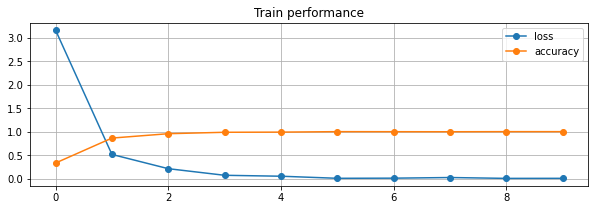

In [121]:
plt.figure(figsize=(10,3))
plt.plot(history.history["loss"], label="loss", marker="o")
plt.plot(history.history["accuracy"], label="accuracy", marker="o")
plt.grid()
plt.legend()
plt.title("Train performance")